In [1]:
import numpy as np
import torch

import json

import matplotlib.pyplot as plt

import deblending_runjingdev.starnet_lib as starnet_lib

from deblending_runjingdev.which_device import device

In [2]:
np.random.seed(5759)
_ = torch.manual_seed(1345)

# Get image

In [3]:
test_image_file = '../test_image_100x100.npz'
full_image = torch.Tensor(np.load(test_image_file)['image']).unsqueeze(0).to(device)
true_locs = torch.Tensor(np.load(test_image_file)['locs']).to(device)

In [4]:
slen = full_image.shape[-1]

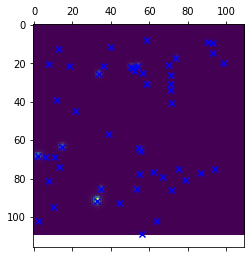

In [5]:
plt.matshow(full_image[0, 0].cpu())
plt.scatter(true_locs[:, 1].cpu() * (slen - 1), 
            true_locs[:, 0].cpu() * (slen - 1), 
            color = 'blue', marker = 'x')

# Optimization trace plots

In [6]:
elbo_encoder_file = '../fits/results_100x100/starnet_elbo'
sleep_encoder_file = '../fits/results_100x100/starnet_klpq'

In [7]:
def plot_optimization_traceplot(encoder_file, ax, label = '', color = 'blue'): 
    
    elbo_results_saved = np.loadtxt(encoder_file + '-elbo_results')

    time_vec = elbo_results_saved[:, -1]
    elbo_vec = elbo_results_saved[:, 3]
    
    ax.semilogy(time_vec - time_vec[0],
                elbo_vec,
                linestyle = '-', 
                label = label, 
                color = color,
                lw = 3)

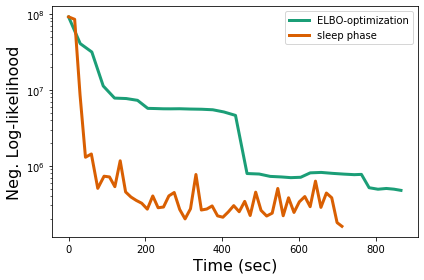

In [8]:
fig, axarr = plt.subplots(1, 1, figsize=(6, 4))

plot_optimization_traceplot(elbo_encoder_file,
                            axarr, 
                            label = 'ELBO-optimization', 
                            color = '#1b9e77')

plot_optimization_traceplot(sleep_encoder_file,
                            axarr, 
                            label = 'sleep phase', 
                            color = '#d95f02')

axarr.legend()

axarr.set_xlabel('Time (sec)', fontsize = 16)
axarr.set_ylabel('Neg. Log-likelihood', fontsize = 16)

fig.tight_layout()

# Print detections

In [9]:
elbo_encoder = starnet_lib.StarEncoder(slen = slen, 
                                       ptile_slen = 20,
                                       step = 10,
                                       edge_padding = 5,
                                       n_bands = 2,
                                       max_detections = 2, 
                                       fmin = 1000., 
                                       constrain_logflux_mean = True,
                                       track_running_stats = False)

elbo_encoder.load_state_dict(torch.load(elbo_encoder_file,
                               map_location=lambda storage, loc: storage))
elbo_encoder.to(device);
elbo_encoder.eval(); 

In [10]:
sleep_encoder = starnet_lib.StarEncoder(slen = slen,
                                        ptile_slen = 20,
                                        step = 10,
                                        edge_padding = 5,
                                        n_bands = 2,
                                        max_detections = 2)

sleep_encoder.load_state_dict(torch.load(sleep_encoder_file,
                               map_location=lambda storage, loc: storage))
sleep_encoder.to(device);
sleep_encoder.eval(); 

In [11]:
def plot_detections(star_encoder, ax): 
    map_locs = star_encoder.sample_star_encoder(full_image, 
                                                 return_map_n_stars = True,
                                                 return_map_star_params = True,
                                                 n_samples = 1)[0]
        
    # plot detections
    ax.scatter(map_locs[0, :, 1].cpu() * (slen - 1), 
               map_locs[0, :, 0].cpu() * (slen - 1), 
               color = 'red',
               marker = 'x', 
               label = 'Est.')

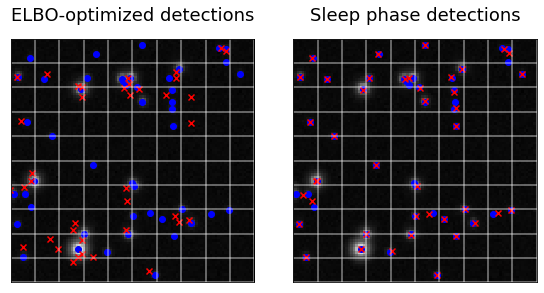

In [12]:
fig, axarr = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

for i in range(2): 
    # plot image
    axarr[i].matshow(torch.log(full_image[0, 0]).cpu(), cmap=plt.cm.gray)
    
    # plot true locations
    axarr[i].scatter(true_locs[:, 1].cpu() * (slen - 1), 
                     true_locs[:, 0].cpu() * (slen - 1), 
                     color = 'blue')
    
    axarr[i].set_yticks([])
    axarr[i].set_xticks([])
    
    axarr[i].set_xlim(5, 105)
    axarr[i].set_ylim(105, 5)
    
    # plot tiles
    for j in range(11): 
        axarr[i].axvline(elbo_encoder.edge_padding + j * elbo_encoder.step, color = 'white', alpha = 0.5)
        axarr[i].axhline(elbo_encoder.edge_padding + j * elbo_encoder.step, color = 'white', alpha = 0.5)

        
# plot detections
plot_detections(elbo_encoder, axarr[0])
plot_detections(sleep_encoder, axarr[1])

axarr[0].set_title('ELBO-optimized detections', fontsize = 18)
axarr[1].set_title('Sleep phase detections', fontsize = 18)

fig.tight_layout()